In [226]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



print("Pandas Version : {}".format(pd.__version__))
print("Numpy  Version : {}".format(np.__version__))
print("Seaborn Version : {}".format(sns.__version__))
print("Matplotlib Version : {}".format(matplotlib.__version__))


Pandas Version : 1.5.0
Numpy  Version : 1.23.4
Seaborn Version : 0.12.0
Matplotlib Version : 3.6.2


## Load and Inspect Data

In [227]:
## Load and Inspect Data

bike_df = pd.read_csv("day.csv",header=0,sep=',',index_col=0, low_memory=False)
bike_df.head()



dteday  season  yr  mnth  holiday  weekday  workingday  \
instant                                                               
1        01-01-2018       1   0     1        0        6           0   
2        02-01-2018       1   0     1        0        0           0   
3        03-01-2018       1   0     1        0        1           1   
4        04-01-2018       1   0     1        0        2           1   
5        05-01-2018       1   0     1        0        3           1   

         weathersit       temp     atemp      hum  windspeed  casual  \
instant                                                                
1                 2  14.110847  18.18125  80.5833  10.749882     331   
2                 2  14.902598  17.68695  69.6087  16.652113     131   
3                 1   8.050924   9.47025  43.7273  16.636703     120   
4                 1   8.200000  10.60610  59.0435  10.739832     108   
5                 1   9.305237  11.46350  43.6957  12.522300      82   

         registered   cnt  
instant                    
1               654   985  
2               670   801  
3              1229  1349  
4              1454  1562  
5              1518  1600

In [228]:
bike_df.describe().T

count         mean          std        min          25%  \
season      730.0     2.498630     1.110184   1.000000     2.000000   
yr          730.0     0.500000     0.500343   0.000000     0.000000   
mnth        730.0     6.526027     3.450215   1.000000     4.000000   
holiday     730.0     0.028767     0.167266   0.000000     0.000000   
weekday     730.0     2.997260     2.006161   0.000000     1.000000   
workingday  730.0     0.683562     0.465405   0.000000     0.000000   
weathersit  730.0     1.394521     0.544807   1.000000     1.000000   
temp        730.0    20.319259     7.506729   2.424346    13.811885   
atemp       730.0    23.726322     8.150308   3.953480    16.889713   
hum         730.0    62.765175    14.237589   0.000000    52.000000   
windspeed   730.0    12.763620     5.195841   1.500244     9.041650   
casual      730.0   849.249315   686.479875   2.000000   316.250000   
registered  730.0  3658.757534  1559.758728  20.000000  2502.250000   
cnt         730.0  4508.006849  1936.011647  22.000000  3169.750000   

                    50%          75%          max  
season         3.000000     3.000000     4.000000  
yr             0.500000     1.000000     1.000000  
mnth           7.000000    10.000000    12.000000  
holiday        0.000000     0.000000     1.000000  
weekday        3.000000     5.000000     6.000000  
workingday     1.000000     1.000000     1.000000  
weathersit     1.000000     2.000000     3.000000  
temp          20.465826    26.880615    35.328347  
atemp         24.368225    30.445775    42.044800  
hum           62.625000    72.989575    97.250000  
windspeed     12.125325    15.625589    34.000021  
casual       717.000000  1096.500000  3410.000000  
registered  3664.500000  4783.250000  6946.000000  
cnt         4548.500000  5966.000000  8714.000000

In [229]:
bike_df.info(max_cols=None, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 91.2+ KB


In [230]:
# Do we have any nan ?
bike_df.isnull().values.any()

False

In [231]:
# Do we have any variables with just one value ? Such variables won't add much value
# Also our target variable is "total count" of users 
# There is no bsuiness information provided around special treatment needed for registered or casual users
# So we will drop those two types of users and use total count only.

cols_valcounts = {}
col_valcounts = { cols:bike_df[cols].unique() for cols in bike_df.columns }

# drop columns with only 1 or less type of value in addition to few more not adding value to analysis.
cols_to_drop = [ col for col,val in col_valcounts.items() if len(val) <=1 ]
cols_to_drop.extend(['casual', 'registered'])
print(len(cols_to_drop))
bike_df =  bike_df.drop(labels=cols_to_drop,axis=1)
print(bike_df.shape)


2
(730, 13)


In [232]:
# Now let us do date time conversion. Direct use of date in regression not possible
# we do have month, year and week-day, let us derive day from datetime
cols_to_datetime = ['dteday']
bike_df[cols_to_datetime] = bike_df[cols_to_datetime].apply(lambda x: pd.to_datetime(x,format='%d-%m-%Y'))

# Let us change dteday column now
bike_df['dteday'] = bike_df['dteday'].dt.day
bike_df.head()

dteday  season  yr  mnth  holiday  weekday  workingday  weathersit  \
instant                                                                       
1             1       1   0     1        0        6           0           2   
2             2       1   0     1        0        0           0           2   
3             3       1   0     1        0        1           1           1   
4             4       1   0     1        0        2           1           1   
5             5       1   0     1        0        3           1           1   

              temp     atemp      hum  windspeed   cnt  
instant                                                 
1        14.110847  18.18125  80.5833  10.749882   985  
2        14.902598  17.68695  69.6087  16.652113   801  
3         8.050924   9.47025  43.7273  16.636703  1349  
4         8.200000  10.60610  59.0435  10.739832  1562  
5         9.305237  11.46350  43.6957  12.522300  1600

In [233]:
bike_df.tail()

dteday  season  yr  mnth  holiday  weekday  workingday  weathersit  \
instant                                                                       
726          27       1   1    12        0        4           1           2   
727          28       1   1    12        0        5           1           2   
728          29       1   1    12        0        6           0           2   
729          30       1   1    12        0        0           0           1   
730          31       1   1    12        0        1           1           2   

              temp     atemp      hum  windspeed   cnt  
instant                                                 
726      10.420847  11.33210  65.2917  23.458911  2114  
727      10.386653  12.75230  59.0000  10.416557  3095  
728      10.386653  12.12000  75.2917   8.333661  1341  
729      10.489153  11.58500  48.3333  23.500518  1796  
730       8.849153  11.17435  57.7500  10.374682  2729

## Multicolinearity analyis  - 
- using corelation matrix and pair plots
- using variation inflation factor

In [234]:
sns.pairplot(data=bike_df, kind='reg', size=12)

/Users/dhananjayjoshi/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Pearson correlation coefficient matrix for each independent variable: 
                   dteday        season            yr          mnth   holiday  \
dteday      1.000000e+00  1.925989e-03 -1.809205e-16  1.189318e-02 -0.010371   
season      1.925989e-03  1.000000e+00 -3.279074e-16  8.310321e-01 -0.010868   
yr         -1.809205e-16 -3.279074e-16  1.000000e+00 -5.162656e-16  0.008195   
mnth        1.189318e-02  8.310321e-01 -5.162656e-16  1.000000e+00  0.018905   
holiday    -1.037108e-02 -1.086804e-02  8.195345e-03  1.890483e-02  1.000000   
weekday    -4.318179e-04 -3.081198e-03 -5.466369e-03  9.522969e-03 -0.101962   
workingday  8.520708e-03  1.376178e-02 -2.945396e-03 -4.687953e-03 -0.252948   
weathersit -2.617822e-02  2.130636e-02 -5.032247e-02  4.561335e-02 -0.034395   
temp        2.600883e-02  3.333607e-01  4.878919e-02  2.190833e-01 -0.028764   
atemp       1.992047e-02  3.420139e-01  4.721519e-02  2.264302e-01 -0.032703   
hum         4.029371e-02  2.082196e-01 -1.125471

/var/folders/t7/tq78zv4n6q59rwx2f5c0ktlh0000gn/T/ipykernel_4018/1007846931.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masking = np.zeros_like(corr, dtype = np.bool)


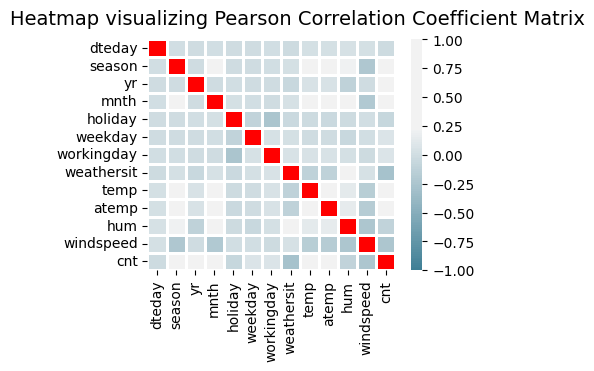

In [235]:
corr = bike_df.corr()  
print('Pearson correlation coefficient matrix for each independent variable: \n', corr)  
  
# Masking the diagonal cells   
masking = np.zeros_like(corr, dtype = np.bool)  
np.fill_diagonal(masking, val = True)  
  
# Initializing a matplotlib figure  
figure, axis = plt.subplots(figsize = (4, 3))  
  
# Generating a custom colormap  
c_map = sns.diverging_palette(223, 14, as_cmap = True, sep = 100)  
c_map.set_bad('red')  
  
# Displaying the heatmap with the masking and the correct aspect ratio  
sns.heatmap(corr, mask = masking, cmap = c_map, vmin = -1, vmax = 1, center = 1, linewidths = 1)  
figure.suptitle('Heatmap visualizing Pearson Correlation Coefficient Matrix', fontsize = 14)  
axis.tick_params(axis = 'both', which = 'major', labelsize = 10)  

In [236]:
# Variance inflation factor


# compute the vif for all given features
def compute_vif(considered_features,df):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X.at[:,'intercept'] = 1
    #X = X.assign('intercept'= 1)
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

X_features = list(bike_df.columns)
X_features.remove('cnt')
print(X_features)
# compute vif 
compute_vif(X_features,bike_df).sort_values('VIF', ascending=False)


['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']


Variable        VIF
9        atemp  64.448021
8         temp  63.430105
1       season   3.541293
3         mnth   3.328050
10         hum   1.930934
7   weathersit   1.754920
11   windspeed   1.201166
4      holiday   1.083223
6   workingday   1.076431
5      weekday   1.024099
2           yr   1.020984
0       dteday   1.011095

In [237]:
# Few conclusions from Correlation, pair graphs and VIF 
# Target variable has correlation with - season, year, month, weathersit, temp, atemp. To some extent holiday and date in the year

# temp and atemp are highly corelated , so one of them can be dropped, since they both would be conveying same information
# we can keep atemp and drop temp at this moment based on very high VIF ( >10)
# Let us drop temp first and look at the impact
X_features.remove('temp')
# compute vif 
compute_vif(X_features,bike_df).sort_values('VIF', ascending=False)

/var/folders/t7/tq78zv4n6q59rwx2f5c0ktlh0000gn/T/ipykernel_4018/219810405.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.at[:,'intercept'] = 1


Variable       VIF
1       season  3.541140
3         mnth  3.328011
9          hum  1.923968
7   weathersit  1.752468
8        atemp  1.234849
10   windspeed  1.170151
4      holiday  1.081646
6   workingday  1.076203
5      weekday  1.021220
2           yr  1.020915
0       dteday  1.008613

In [238]:
# Let us drop temp given that no VIF exceeds 5 
X = bike_df.drop('temp', axis=1)

# Now Let us split data into training and test with test size 0.25 and random_state chosen to get same results 
y = bike_df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X.columns)

(547, 12) (183, 12) (547,) (183,)
Index(['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')


In [239]:
# Let us scale the variables to min-max , which is most stable

mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

In [240]:
# Run Linear regression from sklearn against train data and predict
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Intercept: \n', lr.intercept_)
print('Coefficients: \n', lr.coef_)

y_pred = lr.predict(X_test)
print(y_pred, y_test)

Intercept: 
 431.00000000000455
Coefficients: 
 [ 5.35004565e-12  9.09494702e-13 -1.13686838e-12  1.15818466e-12
 -7.10542736e-13  1.70530257e-12  0.00000000e+00 -1.43245416e-11
  3.60955710e-12 -8.18545232e-12 -2.52953214e-12  8.28300000e+03]
[7460. 4788. 3331. 3068. 7338. 5423. 2046. 2121. 3409. 3620. 2743. 5319.
 2471. 4118. 3606. 2028. 5918. 1550. 6299. 4595. 3376. 4916. 4713. 6304.
 4541. 4602. 2659. 1605. 5191. 2999. 3523. 4511. 1807. 1872. 3372. 4258.
 2177. 2034. 1263. 8555. 2209. 5557. 4991. 7282. 5923. 3570. 6043. 5847.
 5130. 7494. 4911. 3944. 6852. 5634. 5260. 7148. 3956. 6772. 4576. 4390.
 1749. 4845. 4906. 4725. 3831. 2739. 2077. 7333. 3117. 1635. 6196. 5495.
 2765. 1471. 6966. 3922. 1416. 4905. 2431. 4996. 6591. 4569. 2368. 4727.
 2395. 3747. 7175. 3351. 1501. 7040. 5992. 4990. 3727. 4151. 5180. 3577.
 7538. 7335. 4401. 2496. 2077. 7421. 3644. 2566. 3095. 1360. 4322. 2710.
 5267. 4773. 6398. 6861. 1461. 7865. 6421. 2302. 7765. 5558. 3239. 1349.
 6370. 6118. 6211. 2134. 2

In [241]:
# load library
from sklearn.metrics import mean_squared_error

# compute mean_squared errors for both models
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error : {}'.format(np.round(mse,5)))

Mean squared error : 0.0


In [242]:
# Now let us also try same modeling usint stats_model to review stats.

X_train = sm.add_constant(X_train) # adding a constant
X_test = sm.add_constant(X_test) # adding a constant

model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.749e+29
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:11:37   Log-Likelihood:                 12584.
No. Observations:                 547   AIC:                        -2.514e+04
Df Residuals:                     534   BIC:                        -2.509e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        431.0000   8.26e-12   5.22e+13      0.0

Feature: 0, Score: 0.00000000000535004565
Feature: 1, Score: 0.00000000000090949470
Feature: 2, Score: -0.00000000000113686838
Feature: 3, Score: 0.00000000000115818466
Feature: 4, Score: -0.00000000000071054274
Feature: 5, Score: 0.00000000000170530257
Feature: 6, Score: 0.00000000000000000000
Feature: 7, Score: -0.00000000001432454155
Feature: 8, Score: 0.00000000000360955710
Feature: 9, Score: -0.00000000000818545232
Feature: 10, Score: -0.00000000000252953214
Feature: 11, Score: 8283.00000000000000000000
['-0.00000000000071054274', '-0.00000000000113686838', '-0.00000000000252953214', '-0.00000000000818545232', '-0.00000000001432454155', '0.00000000000000000000', '0.00000000000090949470', '0.00000000000115818466', '0.00000000000170530257', '0.00000000000360955710', '0.00000000000535004565', '8283.00000000000000000000']


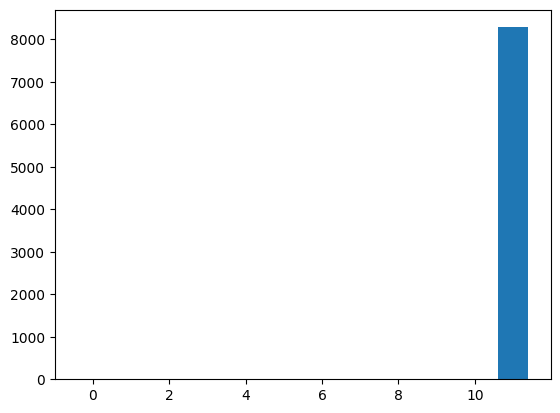

In [243]:
# get importance of features
importance = lr.coef_
# summarize feature importance
imp_list = []
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.20f' % (i,v))
 x = "{:.20f}".format(v)
 imp_list.append(x)

print(sorted(imp_list))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [244]:
# Adjusted R squared value is not largely deviating from R square. It is 1. Also F-statistic value is very low 
# this confirms correct feature selection

from sklearn.metrics import r2_score
r2_score(y_test, y_pred)


1.0